In [1]:
def draw_anotated_pcl(pcl_frames,objs_frames,idx,display=False):
    
    pcl = pcl_frames[idx]
    objs = objs_frames[idx]
    
    %matplotlib inline
    import matplotlib.pylab as plt
    import matplotlib
    from mpl_toolkits.mplot3d import Axes3D
    import math
    # import seaborn as sns; sns.set()
    
    roi_pcl = np.array(pcl)
    px = [p[0] for p in roi_pcl]
    py = [p[1] for p in roi_pcl]
    pz = [p[2] for p in roi_pcl]
    pi = [p[4] for p in roi_pcl]
    n = len(px)
    point_size = 0.05
    axes_limits = [
        [-80,80], # X axis
        [-15,15], # Y axis
        [-3,3] # Z axis
    ]
    
    # Plot x-y, y-z, x-z
    f,ax = plt.subplots(3,1,figsize=(20,5*3))
    # ax = fig.add_subplot(111, projection='3d')
    ax[0].scatter(px,py,c = pi,cmap='gray',s=point_size)
    ax[0].set_xlabel('X axis')
    ax[0].set_ylabel('Y axis')
    ax[0].set_xlim(axes_limits[0])
    ax[0].set_ylim(axes_limits[1])
    
    for obj in objs:
            path = [(p[0],p[1]) for p in obj]
            poly = matplotlib.patches.Polygon(path,fill = False,color='r',linewidth=3)
            ax[0].add_patch(poly)
    ax[1].scatter(py,pz,c = pi,cmap='gray',s=point_size)
    ax[1].set_xlabel('Y axis')
    ax[1].set_ylabel('Z axis')
    ax[1].set_xlim(axes_limits[1])
    ax[1].set_ylim(axes_limits[2])
    ax[2].scatter(px,pz,c = pi,cmap='gray',s=point_size)
    ax[2].set_xlabel('X axis')
    ax[2].set_ylabel('Z axis')
    ax[2].set_xlim(axes_limits[0])
    ax[2].set_ylim(axes_limits[2])
    if display:
        plt.show()
    else:
        filename = 'annotated_video/frame_{0:0>4}.png'.format(idx)
        for sub_ax in ax:
            sub_ax.set_title("Frame: {0:0>4}".format(idx))
    
        plt.savefig(filename)
        plt.close(f)
        return filename
        


In [7]:
def read_objs(filename):
    obs_polygon = []
    with open(filename,'rb') as f:
        while True:
            line = f.readline().split(' ')
            if line[0] == '':
                break
            poly_size = int(line[8])
            poly = []
            for i in range(poly_size):
                poly.append((float(line[9+i*3]),float(line[10+i*3]),float(line[11+i*3])))
            obs_polygon.append(poly)

    return obs_polygon

In [3]:
def annotated_pcl_demo(roi_pcl_frames, obj_frames, name = "pcl", fps = 1, n_frames=0):
    if n_frames == 0:
        n_frames = len(roi_pcl_frames)
    frames = []
    if n_frames > len(roi_pcl_frames):
        n_frames = len(roi_pcl_frames)

    bar = pyprind.ProgBar(n_frames, bar_char='█')

    print('Preparing animation frames...')
    for i in range(n_frames):
        bar.update(i)
        filename = draw_anotated_pcl(roi_pcl_frames, obj_frames, i)
        frames += [filename]
    print('...Animation frames ready.')

    gif_filename = '{0}_data.gif'.format(name)

    clip = ImageSequenceClip(frames, fps=fps)
    try:
        os.remove(gif_filename)
    except OSError:
        pass
    clip.write_gif(gif_filename, fps=fps)

In [4]:
import re
import numpy as np
import os
from tools import *
import pickle
%matplotlib inline

In [5]:
def dump_cnn_out(output_data,filename = 'cnn.out'):
    with open('/data/yulongc/apollo/data/percpt/'+filename,'w') as f:
        # category
        for p in output_data[0][0].flatten():
            f.write('%.15f '%(p))
        # class
        f.write('\n')
        for p_class in output_data[1]:
            for p in p_class.flatten():
                f.write('%.15f '%(p))
            f.write('\n')
        # confidence
        for p in output_data[2][0].flatten():
            f.write('%.15f '%(p))
        f.write('\n')
    #     # heading
    #     for heading in output_data[3]:
    #         for p in heading:
    #             f.write('%.15f '%(p))
        # height
        for p in output_data[3][0].flatten():
            f.write('%.15f '%(p))
        f.write('\n')
        # instance
        for instance in output_data[4]:
            for p in instance.flatten():
                f.write('%.15f '%(p))
            f.write('\n')

In [8]:
objs_frames = []
for i in range(100):
    objs_frames.append(read_objs('/data/yulongc/apollo/data/percpt/builders/builder_{0}.out'.format(i)))

In [9]:
pcl_frames = []
for i in range(100):
    pcl_frames.append(np.loadtxt('/data/yulongc/apollo/data/percpt/pcls/pcl_{0}.out'.format(i)))

In [26]:
annotated_pcl_demo(pcl_frames,objs_frames,name = "annotated_pcl",fps=5)

Preparing animation frames...


0% [███████████████████████████████] 100% | ETA: 23:59:56
Total time elapsed: 00:01:39


...Animation frames ready.

[MoviePy] Building file annotated_pcl_data.gif with imageio


100%|██████████| 100/100 [00:53<00:00,  2.75it/s]


# Dumping CNN Outputs

In [27]:
# caffe model
import caffe
caffe.set_mode_gpu()
# model to attack
model_definition = 'deploy.prototxt'
model_weights = 'deploy.caffemodel'

# init net
net = caffe.Net(model_definition, model_weights, caffe.TEST)

In [30]:
#  ADV CNN OUT

for i in range(500):
    if not i % 50:
        print i
#     features = np.loadtxt('/data/yulongc/apollo/data/percpt/features/features_{0}.out'.format(i))
#     features = np.reshape(features,(8,512,512))

    features = np.load('/data/yulongc/apollo/data/percpt/adv_features/adv_feature_{0}.npy'.format(i))
    features = np.swapaxes(features,0,3)[:,:,:,0]
    
    # transform input
    # input_feature = transform(feature_frames, 0)
    input_feature = features
#     print input_feature.shape

    # get output
    net.blobs['data'].data[0] = input_feature
    net.forward()
    outputs = ['category_score','class_score','confidence_score',
    #            'heading_pt',
               'height_pt','instance_pt']
#     for output in outputs:
#         print output, net.blobs[output].data.shape, net.blobs[output].data.max(), net.blobs[output].data.min()
    output_data = np.copy([net.blobs[output].data[0] for output in outputs])

    dump_cnn_out(output_data,'adv_cnns/cnn_{0}.out'.format(i))

0
50
100
150
200
250
300
350
400
450


In [10]:
adv_objs_frames = []
for i in range(100):
    adv_objs_frames.append(read_objs('/data/yulongc/apollo/data/percpt/adv_builders/adv_builder_{0}.out'.format(i)))

# Visualizing annotaed PCL

In [42]:
annotated_pcl_demo(pcl_frames,adv_objs_frames,name = "adv_annotated_pcl",fps=5)

Preparing animation frames...


0% [███████████████████████████████] 100% | ETA: 23:59:54
Total time elapsed: 00:02:21


...Animation frames ready.

[MoviePy] Building file adv_annotated_pcl_data.gif with imageio


100%|██████████| 100/100 [01:00<00:00,  1.52it/s]


In [16]:
import matplotlib.pylab as plt
import seaborn as sns
np.random.seed(sum(map(ord, "aesthetics")))
sns.set()

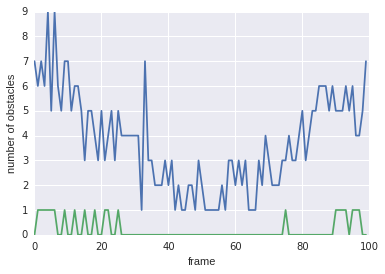

In [18]:
plt.plot(range(100),[len(objs) for objs in objs_frames])
plt.plot(range(100),[len(objs) for objs in adv_objs_frames])
plt.xlabel('frame')
plt.ylabel('number of obstacles')